# Documentation for Conditioanl Calibration Script

## Overview
This script performs fairness calibration for multiple entity resolution tasks and models. It aims to evaluate and reduce fairness disparities using metrics like Equal Opportunity (EO) and Equalized Odds (EOD). The results are evaluated before and after calibration to assess the impact on fairness and predictive accuracy.

## Libraries and Modules
- **os**: Used for working with directories.
- **pickle**: Loads and saves dictionaries for storing sensitive attributes.
- **numpy** and **pandas**: Provide essential data manipulation capabilities.
- **fairness** and **Calibrate**: Import functions for fairness evaluation and calibration.

## Code Structure
1. **Loading Sensitive Attributes**:
   - The script loads dictionaries containing sensitive attributes for validation and training data using `pickle`.

2. **Initialization**:
   - Initializes an empty results dictionary.
   - Defines the tasks and models to iterate over for fairness evaluation.

3. **Loop Through Tasks and Models**:
   - For each combination of `task` and `model`:
     - Initializes storage for results before and after calibration.
     - Iterates through `EO` and `EOD` metrics to collect data.

4. **Loading Validation Data**:
   - Loads the validation scores and merges the scores for training and validation data.
   - Retrieves the probability and true label columns from the loaded dataset.

5. **Threshold Split and Calibration**:
   - Splits the data into probabilities above and below a given threshold.
   - Uses the `get_fairness_objects` function to extract necessary statistics for fairness calibration.
   - Calibrates the probabilities to adjust for fairness disparity.

6. **Normalization and Metric Calculation**:
   - Normalizes the calibrated scores if they fall outside the `[0, 1]` range.
   - Calculates disparity metrics using `_stats_calibrate`, which evaluates:
     - Disparities in EO and EOD.
     - Overall predictive accuracy (`AUC`).

7. **Determine Optimal Threshold**:
   - Determines the threshold that minimizes the disparity metric for EO or EOD.
   - Loads test data and repeats calibration for test samples using the optimal threshold.

8. **Evaluation Before and After Calibration**:
   - Calculates fairness metrics before and after calibration on the test data.
   - Stores results in a dictionary for each combination of task, model, and metric type (EO/EOD).

9. **Saving Results**:
   - Saves the final results to a pickle file for future use.

## Key Parameters
- **Tasks**: List of entity matching datasets (`Fodors-Zagat`, `DBLP-GoogleScholar`, etc.).
- **Models**: List of entity matching models (`deepmatcher`, `DITTO`, etc.).
- **Thresholds**: A set of 20 evenly spaced thresholds between `[0, 1]` for calibration.

## Functions
- **get_fairness_objects**: Extracts required statistics from sensitive groups to use in fairness calibration.
- **get_fair_estimation**: Estimates fairness-adjusted probabilities for sensitive and non-sensitive groups.
- **_stats_calibrate**: Evaluates fairness metrics such as disparity in Equal Opportunity (`EO`), Equalized Odds (`EOD`), and Disparate Impact (`DP`).

## Output
- **Results Dictionary**: Contains fairness metrics before and after calibration for each task-model combination.
- **Printed Metrics**: Displays disparity metrics before and after calibration, including AUC and threshold information.
- **Pickle File**: Saves the entire result dictionary for future analysis.

## Example Usage
- To evaluate fairness for new models and tasks, add their respective names to the `models` and `tasks` lists.
- To modify thresholds, change the parameters in `np.linspace`.

## Notes
- The script uses validation data to determine the optimal threshold for fairness calibration.
- Fairness metrics are calculated both before and after applying calibration.
- The success of fairness calibration depends on the similarity of score distributions between validation and test sets.

Feel free to ask for further clarifications or adjustments to this documentation.


-----
## Step1: save the calibration results

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from fairness import *
from Calibrate import *
from Calibrate import _stats_calibrate

# Load sensitive attribute dictionaries
with open('saved_params/sens_attr_dict_valid.pkl', 'rb') as file:
    sens_attr_dict_valid = pickle.load(file)

with open('saved_params/sens_attr_dict_train.pkl', 'rb') as file:
    sens_attr_dict_train = pickle.load(file)

# Initialize result dictionary
results = {}

# Define paths and parameters
base_path = os.getcwd()
tasks = ['Fodors-Zagat', 'DBLP-GoogleScholar', 'iTunes-Amazon', 'Walmart-Amazon', 'Amazon-Google', 'Beer', 'DBLP-ACM']
models = ['deepmatcher', 'DITTO', 'EMTransformer', 'HierGAT', 'HierMatcher']

# Iterate over each task and model
for task in tasks:
    results[task] = {}
    for model in models:
        results[task][model] = {
            'EOD_min': {},
            'EO_min': {},
        }
        
        for metric in ['EOD', 'EO']:
            disparity_values = []
            thresholds = []
            
            for threshold in np.linspace(0, 1, 20):
                try:
                    # Load validation scores and sensitive attributes
                    scores_valid = pd.concat([
                        pd.read_csv(f'{base_path}/scores/{task}_{model}/score_train.csv'),
                        pd.read_csv(f'{base_path}/scores/{task}_{model}/score_valid.csv')
                    ])
                    
                    sens_valid = np.concatenate((
                        sens_attr_dict_train[task],
                        sens_attr_dict_valid[task]
                    ))
                    
                    # Extract probability and true label columns
                    for column in scores_valid.columns:
                        if len(np.unique(scores_valid[column])) > 2:
                            prob_valid = scores_valid[column]
                        else:
                            y_valid = scores_valid[column]
                    
                    # Split data based on threshold
                    prob_above_thresh = prob_valid[prob_valid > threshold]
                    sens_above_thresh = sens_valid[prob_valid > threshold]
                    prob_below_thresh = prob_valid[prob_valid <= threshold]
                    sens_below_thresh = sens_valid[prob_valid <= threshold]
                    
                    # Get fairness objects for calibration
                    p1_pos, e1_pos, q1_pos = get_fairness_objects(sens_above_thresh, 
                                                                  np.array(prob_above_thresh[sens_above_thresh == 0]), 
                                                                  np.array(prob_above_thresh[sens_above_thresh == 1]))
                    p1_neg, e1_neg, q1_neg = get_fairness_objects(sens_below_thresh, 
                                                                  np.array(prob_below_thresh[sens_below_thresh == 0]), 
                                                                  np.array(prob_below_thresh[sens_below_thresh == 1]))
                    
                    # Calibrate probabilities
                    calibrated_probs = []
                    for idx, prob in enumerate(prob_valid):
                        if sens_valid[idx] == 1:
                            in_0 = np.array([]).reshape(-1,)
                            in_1 = np.array([prob]).reshape(-1,)
                        else:
                            in_0 = np.array([prob]).reshape(-1,)
                            in_1 = np.array([]).reshape(-1,)
                        
                        if prob > threshold:
                            fair_non_sensitive, fair_sensitive = get_fair_estimation(p1_pos, e1_pos, q1_pos, in_0, in_1, jitter=0)
                        else:
                            fair_non_sensitive, fair_sensitive = get_fair_estimation(p1_neg, e1_neg, q1_neg, in_0, in_1, jitter=0)
                        
                        calibrated_probs.append(fair_sensitive[0] if len(fair_sensitive) > 0 else fair_non_sensitive[0])
                    
                    # Create calibrated prediction DataFrame
                    pred_fair = pd.DataFrame({'original': prob_valid, 'calibrated': calibrated_probs})
                    
                    # Normalize calibrated probabilities if necessary
                    if (pred_fair['calibrated'] < 0).any() or (pred_fair['calibrated'] > 1).any():
                        min_val = pred_fair['calibrated'].min()
                        pred_fair['calibrated'] -= min_val
                        max_val = pred_fair['calibrated'].max()
                        pred_fair['calibrated'] /= max_val
                    
                    # Calculate fairness metrics
                    dsp_eod, dsp_eo, dsp_dp, auc, frac = _stats_calibrate(sens_valid, pred_fair['calibrated'], y_valid)
                    
                    # Append results
                    if metric == 'EO':
                        disparity_values.append(dsp_eo)
                    else:
                        disparity_values.append(dsp_eod)
                    
                    thresholds.append(threshold)
                except Exception as e:
                    continue
            
            # Load test data and sensitive attributes
            with open('saved_params/sens_attr_dict_test.pkl', 'rb') as file:
                sens_attr_dict_test = pickle.load(file)
            
            scores_test = pd.read_csv(f'{base_path}/scores/{task}_{model}/score_test.csv')
            sens_test = sens_attr_dict_test[task]
            
            for column in scores_test.columns:
                if len(np.unique(scores_test[column])) > 2:
                    prob_test = scores_test[column]
                else:
                    y_test = scores_test[column]
            
            # Find optimal threshold
            optimal_threshold = thresholds[np.argmin(disparity_values)]
            
            
            # Fairness metrics before calibration
            if metric == 'EOD':
                dsp_eod_before, dsp_eo_before, dsp_dp_before, auc_before, _ = _stats_calibrate(sens_test, prob_test, y_test)
                print(f'Before Calibration - Task: {task}, Model: {model}, DP: {dsp_dp_before:.2f}, EO: {dsp_eo_before:.2f}, EOD: {dsp_eod_before:.2f}, AUC: {auc_before} \n')
            
            # Calibrate test probabilities
            prob_above_thresh_test = prob_test[prob_test > optimal_threshold]
            sens_above_thresh_test = sens_test[prob_test > optimal_threshold]
            prob_below_thresh_test = prob_test[prob_test <= optimal_threshold]
            sens_below_thresh_test = sens_test[prob_test <= optimal_threshold]
            
            p1_pos, e1_pos, q1_pos = get_fairness_objects(sens_above_thresh_test, 
                                                          np.array(prob_above_thresh_test[sens_above_thresh_test == 0]), 
                                                          np.array(prob_above_thresh_test[sens_above_thresh_test == 1]))
            p1_neg, e1_neg, q1_neg = get_fairness_objects(sens_below_thresh_test, 
                                                          np.array(prob_below_thresh_test[sens_below_thresh_test == 0]), 
                                                          np.array(prob_below_thresh_test[sens_below_thresh_test == 1]))
            
            calibrated_probs_test = []
            for idx, prob in enumerate(prob_test):
                if sens_test[idx] == 1:
                    in_0 = np.array([]).reshape(-1,)
                    in_1 = np.array([prob]).reshape(-1,)
                else:
                    in_0 = np.array([prob]).reshape(-1,)
                    in_1 = np.array([]).reshape(-1,)
                
                if prob > optimal_threshold:
                    fair_non_sensitive, fair_sensitive = get_fair_estimation(p1_pos, e1_pos, q1_pos, in_0, in_1, jitter=0)
                else:
                    fair_non_sensitive, fair_sensitive = get_fair_estimation(p1_neg, e1_neg, q1_neg, in_0, in_1, jitter=0)
                
                calibrated_probs_test.append(fair_sensitive[0] if len(fair_sensitive) > 0 else fair_non_sensitive[0])
            
            pred_fair_test = pd.DataFrame({'original': prob_test, 'calibrated': calibrated_probs_test})
            
            # Normalize calibrated probabilities if necessary
            if (pred_fair_test['calibrated'] < 0).any() or (pred_fair_test['calibrated'] > 1).any():
                min_val = pred_fair_test['calibrated'].min()
                pred_fair_test['calibrated'] -= min_val
                max_val = pred_fair_test['calibrated'].max()
                pred_fair_test['calibrated'] /= max_val
            
            # Fairness metrics after calibration
            metric_key = 'EO_min' if metric == 'EO' else 'EOD_min'
            dsp_eod_after, dsp_eo_after, dsp_dp_after, auc_after, _ = _stats_calibrate(sens_test, pred_fair_test['calibrated'], y_test)
            print(f'After Calibration - Task: {task}, Model: {model}, Optimized for: {metric}, Gamma: {round(optimal_threshold,3)}, DP: {dsp_dp_after:.2f}, EO: {dsp_eo_after:.2f}, EOD: {dsp_eod_after:.2f}, AUC: {auc_after}')
            
            # Save results
            results[task][model][metric_key] = {
                'before': {
                    'DP': dsp_dp_before,
                    'EO': dsp_eo_before,
                    'EOD': dsp_eod_before,
                    'AUC': auc_before
                },
                'after': {
                    'optimal_threshold': optimal_threshold,
                    'DP': dsp_dp_after,
                    'EO': dsp_eo_after,
                    'EOD': dsp_eod_after,
                    'AUC': auc_after
                }
            }

        print('-------\n')
    
    

# # Dump the results to a pickle file
# with open('saved_params/repair_label_wise_result.pkl', 'wb') as file:
#     pickle.dump(results, file)


Before Calibration - Task: Fodors-Zagat, Model: deepmatcher, DP: 2.86, EO: 5.51, EOD: 5.51, AUC: 100.0 

After Calibration - Task: Fodors-Zagat, Model: deepmatcher, Optimized for: EOD, Gamma: 0.105, DP: 3.06, EO: 1.11, EOD: 1.11, AUC: 100.0
After Calibration - Task: Fodors-Zagat, Model: deepmatcher, Optimized for: EO, Gamma: 0.105, DP: 3.06, EO: 1.11, EOD: 1.11, AUC: 100.0
-------



-----
## step2: plot the conditioanl calibration results

In [2]:
import numpy as np
import pandas as pd
from fairness import *
import pickle
import matplotlib.pyplot as plt
from fig_params import *

# Load results
with open('saved_params/repair_label_wise_result.pkl', 'rb') as file:
    RES = pickle.load(file)

with open('saved_params/repair_result.pkl', 'rb') as file:
    RES_orig = pickle.load(file)

# Parameters
bar_fig_size = (15, 9)  # Size of the bar plot figure
x_labels = ['Deep\nMatcher', 'DITTO', 'HierGAT', 'EMTran', 'Hmatch']
bar_width = 0.4  # Width of each bar
x = np.arange(len(x_labels))  # X positions for groups
tasks = ['Fodors-Zagat', 'DBLP-GoogleScholar', 'iTunes-Amazon', 'Walmart-Amazon', 'Amazon-Google', 'Beer', 'DBLP-ACM']
models = ['deepmatcher', 'DITTO', 'HierGAT', 'EMTransformer', 'HierMatcher']

# Plotting function
def plot_metric(task, metric_name, y_label, file_suffix, color_before, color_after, edge_color_before, edge_color_after, legend_loc='best'):
    plt.figure(figsize=bar_fig_size)
    
    # Before repair
    
    Y_before = [RES_orig['m2'][model][task]['before'][metric_name] for model in models]
    bars_before = plt.bar(x - bar_width / 2 - 0.004, Y_before, width=bar_width, color=color_before, alpha=fig_alpha, edgecolor=edge_color_before, label='Before')
    for bar in bars_before:
        bar.set_linewidth(bar_border_l)
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.03, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=20)
    
    # After repair
    if metric_name == 'AUC': metric_name = 'auc'
    Y_after = [RES[task][model]['EOD_min']['after'][metric_name] if metric_name == 'EOD' else RES[task][model]['EO_min']['after'][metric_name] for model in models]
    bars_after = plt.bar(x + bar_width / 2 + 0.004, Y_after, width=bar_width, color=color_after, alpha=fig_alpha, edgecolor=edge_color_after, label='After')
    for bar in bars_after:
        bar.set_linewidth(bar_border_l)
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2 + 0.03, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=20)
    
    # Formatting
    plt.ylabel(y_label, fontsize=bar_yax_F - 10)
    plt.xticks(x, x_labels, fontsize=bar_xax_F, rotation=0)
    plt.yticks(fontsize=bar_yax_F)
    plt.tick_params(axis='y', which='both', length=tick_l, width=tick_w)
    plt.tick_params(axis='x', which='both', length=tick_l_bar, width=tick_w_bar)
    plt.title(task, fontsize=25)
    plt.ylim([50, 103] if metric_name == 'AUC' else None)
    plt.legend(fontsize=bar_legend_F - 15, loc=legend_loc)
    plt.tight_layout()
    plt.savefig(f'FIGURES/{metric_name}_{task}_{file_suffix}.pdf')
    plt.close()

# Plot metrics
for task in tasks:
    plot_metric(task, 'AUC', 'AUC', 'alg2', "#CC79A7", "#009E73", '#8A3F5B', '#003D3D', 'lower left')
    plot_metric(task, 'EOD', 'EOD', 'alg2', "#CC79A7", "#009E73", '#8A3F5B', '#003D3D')
    plot_metric(task, 'EO', 'EO', 'alg2', "#CC79A7", "#009E73", '#8A3F5B', '#003D3D')



---
## Step3: plot a detailed example

-------


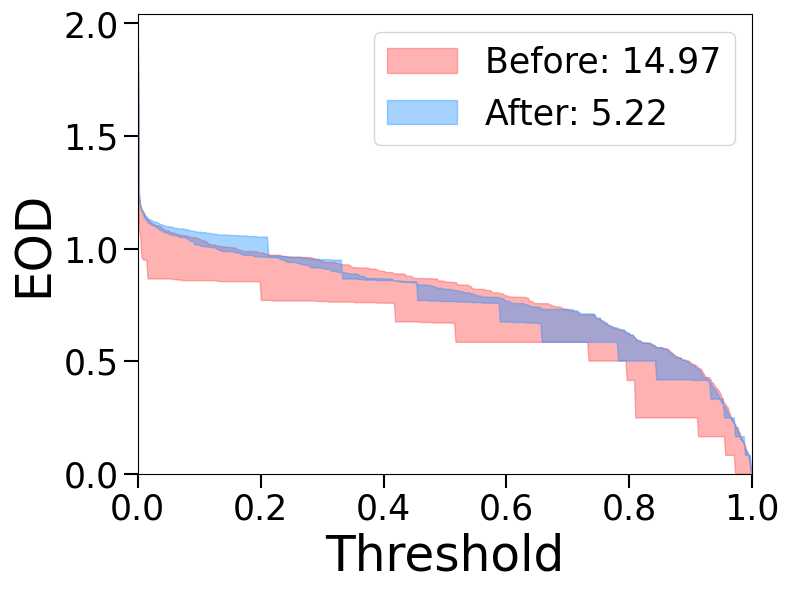

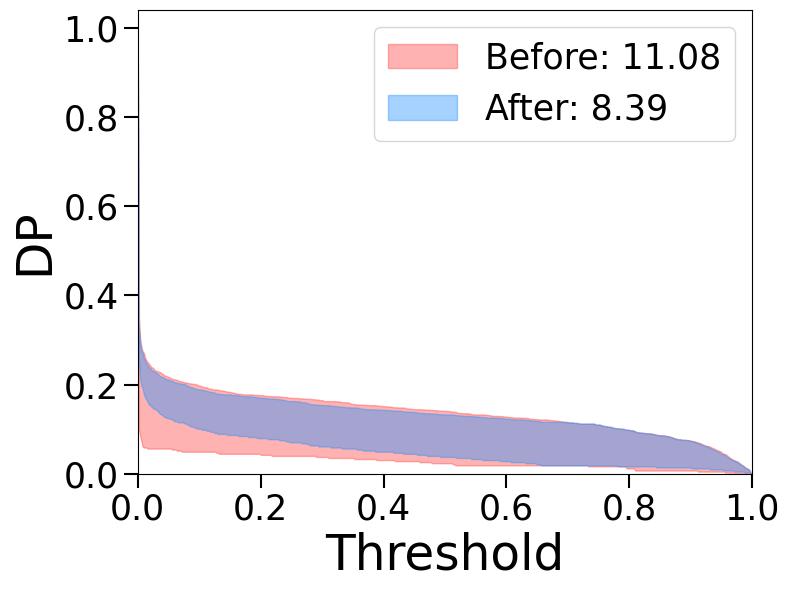

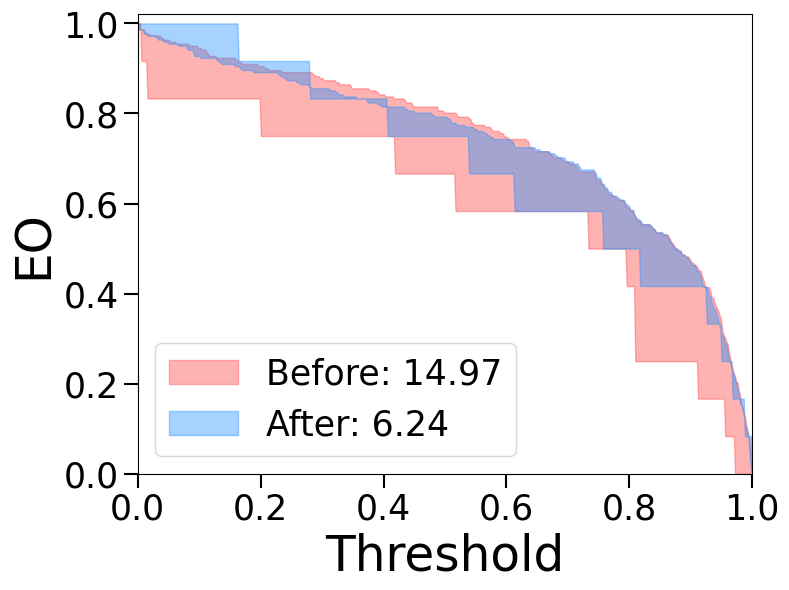

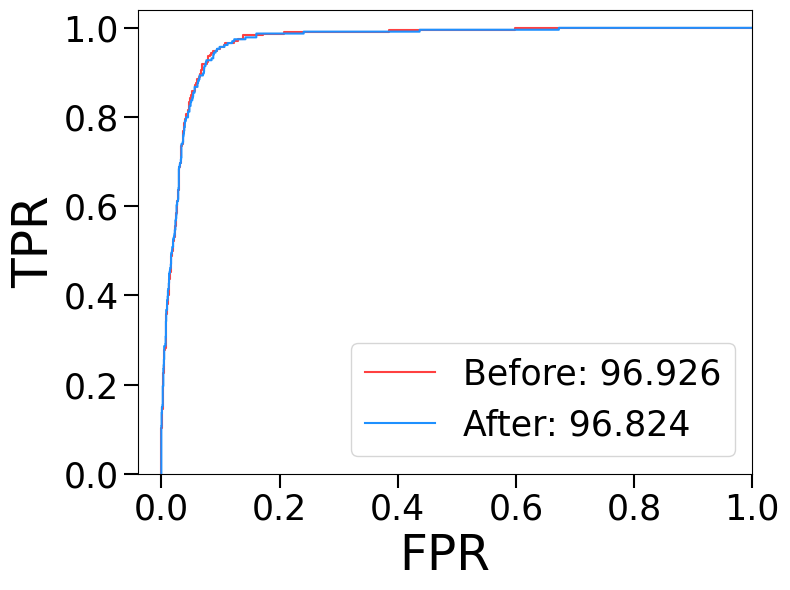

In [ ]:
import numpy as np
import pandas as pd
from fairness import *
import pickle
import os

# Load sensitivity attribute dictionaries and threshold label-wise result for validation and training data
with open('saved_params/sens_attr_dict_valid.pkl', 'rb') as file:
    sens_attr_dict_valid = pickle.load(file)

with open('saved_params/sens_attr_dict_train.pkl', 'rb') as file:
    sens_attr_dict_train = pickle.load(file)

with open('saved_params/repair_label_wise_result.pkl', 'rb') as file:
    thresh_lbl = pickle.load(file)

# Initialize result dictionaries
RES = {}
result_dict = {}

# Set task and model parameters
task = 'Amazon-Google'
model = 'HierGAT'

# Loop through fairness metrics
for rpt in ['EOD', 'EO']:
    K = 'EO_min' if rpt == 'EO' else 'EOD_min'

    # Retrieve threshold for calibration
    TH = thresh_lbl[task][model][K]['after']['gamma']

    # Load sensitivity attribute dictionary for test data
    with open('saved_params/sens_attr_dict_test.pkl', 'rb') as file:
        sens_attr_dict_test = pickle.load(file)

    # Load test data and model scores
    df_test = pd.read_csv(os.path.join(os.getcwd(), 'DataDir', task, 'test.csv'))
    scores_test = pd.read_csv(os.path.join(os.getcwd(), 'scores', f'{task}_{model}', 'score_test.csv'))
    sens_test = sens_attr_dict_test[task]

    # Separate probability and label columns in scores
    for x in list(scores_test.columns):
        if len(np.unique(scores_test[x])) > 2:  
            prob_test = scores_test[x]
        else: 
            y_test = scores_test[x]

    # Calculate initial calibration statistics
    DSP_EOD, DSP_EO, DSP_DP, auc_all, Frac = _stats_calibrate(sens_test, prob_test, y_test)

    # Apply jitter for calibration adjustments
    jitter = 0
    prob_test2 = prob_test + np.random.uniform(-jitter, jitter, prob_test.shape)

    # Define fairness objects for positive and negative samples
    prob_test2_ = prob_test2[prob_test2 > TH]
    sens_test_ = sens_test[prob_test2 > TH]
    p1_pos, e1_pos, q1_pos = get_fairness_objects(sens_test_, np.array(prob_test2_[sens_test_ == 0]), np.array(prob_test2_[sens_test_ == 1]))

    prob_test2_ = prob_test2[prob_test2 <= TH]
    sens_test_ = sens_test[prob_test2 <= TH]
    p1_neg, e1_neg, q1_neg = get_fairness_objects(sens_test_, np.array(prob_test2_[sens_test_ == 0]), np.array(prob_test2_[sens_test_ == 1]))

    # Calibrate each test prediction based on fairness adjustment
    CALIBRATED = []
    for idx, pnt in enumerate(prob_test):
        in_0, in_1 = ((np.array([pnt])).reshape(-1, ), (np.array([])).reshape(-1, )) if sens_test[idx] == 0 else ((np.array([])).reshape(-1, ), (np.array([pnt])).reshape(-1, ))

        fair_nonsensitive, fair_sensitive = get_fair_estimation(
            p1_pos, e1_pos, q1_pos, in_0, in_1, jitter=jitter) if pnt > TH else get_fair_estimation(p1_neg, e1_neg, q1_neg, in_0, in_1, jitter=jitter)
        
        CALIBRATED.append(list(fair_nonsensitive)[0] if list(fair_sensitive) == [] else list(fair_sensitive)[0])

    # Normalize calibrated predictions if out of bounds
    pred_fair = pd.DataFrame(prob_test.copy())
    pred_fair['calibrated'] = CALIBRATED
    if (np.sum(pred_fair['calibrated'] < 0) + np.sum(pred_fair['calibrated'] > 1)) > 0:
        min_val = pred_fair['calibrated'].min()
        pred_fair['calibrated'] -= min_val
        max_val = pred_fair['calibrated'].max()
        pred_fair['calibrated'] /= max_val

    # Calculate post-calibration statistics
    DSP_EOD2, DSP_EO2, DSP_DP2, auc_all2, Frac = _stats_calibrate(sens_test, pred_fair['calibrated'], y_test)


    res = np.array(list(pred_fair['calibrated']))
    score_optimal_Eop,score_optimal_Eodd,score_optimal_PR, model,dataset,sens_attr, y_true, score= res,res,res, model,task,sens_test, np.array(y_test), np.array(pred_fair[pred_fair.columns[0]])
    y_score = score

    Eodd_disp_init = calc_EO_disp(sens_attr, y_true, y_score)
    auc_init = roc_auc_score(y_true, y_score)
    PR_disp_init = calc_DP_PR(sens_attr, y_true, y_score)
    Eop_disp_init = calc_DP_TPR(sens_attr, y_true, y_score)


    range = np.linspace(0, 1, 500)
    Eop_disp = calc_DP_TPR(sens_attr, y_true, score_optimal_Eop)
    auc_Eop = roc_auc_score(y_true, score_optimal_Eop)

    E_op_g1,E_op_g2 =[], []
    for TH in range:
        y_pred = np.array([1 if score > TH else 0 for score in y_score])
        E_op_g1, E_op_g2,_, _ = E_make(E_op_g1, E_op_g2,[], [], y_true,y_pred,  sens_attr)


    E_op_g1_calib,E_op_g2_calib =[], []
    for TH in range:
        y_pred = np.array([1 if score > TH else 0 for score in score_optimal_Eop])
        E_op_g1_calib, E_op_g2_calib,_, _ = E_make(E_op_g1_calib, E_op_g2_calib,[], [], y_true,y_pred,  sens_attr)
        

    AUC_init ,_, _ = AUC_make(y_true, y_score, sens_attr)
    AUC_Eop ,_, _ = AUC_make(y_true, score_optimal_Eop, sens_attr)


    ########################################  

    Eodd_disp = calc_EO_disp(sens_attr, y_true, score_optimal_Eodd)
    auc_Eodd = roc_auc_score(y_true, score_optimal_Eodd)
    AUC_Eod ,_, _ = AUC_make(y_true, score_optimal_Eodd, sens_attr)


    E_od_g1, E_od_g2 =[], []
    for TH in range:
        y_pred = np.array([1 if score > TH else 0 for score in y_score])
        _, _,E_od_g1, E_od_g2 = E_make([], [],E_od_g1, E_od_g2, y_true,y_pred,  sens_attr)
        
    E_od_g1_calib, E_od_g2_calib =[], []
    for TH in range:
        y_pred = np.array([1 if score > TH else 0 for score in score_optimal_Eodd])
        _, _,E_od_g1_calib, E_od_g2_calib = E_make([], [],E_od_g1_calib, E_od_g2_calib, y_true,y_pred,  sens_attr)
        


    ########################################  

    PR_disp = calc_DP_PR(sens_attr, y_true, score_optimal_PR)
    auc_PR = roc_auc_score(y_true, score_optimal_PR)


    AUC_PR ,_, _ = AUC_make(y_true, score_optimal_PR, sens_attr)


    PR_g1, PR_g2 = [], []

    for TH in range:
        y_pred = np.array([1 if score > TH else 0 for score in y_score])
        _, PR_g1, PR_g2 = PR_make([], PR_g1, PR_g2,y_true, y_pred , sens_attr)



    PR_g1_calib, PR_g2_calib = [], []
    for TH in range:
        y_pred = np.array([1 if score > TH else 0 for score in score_optimal_PR])
        _, PR_g1_calib, PR_g2_calib = PR_make([], PR_g1_calib, PR_g2_calib,y_true, y_pred , sens_attr)





    L = 1.5
    F = 25
    F_legend = 28
    F_title = 35
    size = (8,6)



    tick_l = 10
    tick_w = 1.5
    F_ax = 25
    F_lbl = 35

    fig_alpha = 0.65
    F_legend = 25


    if rpt == 'EOD':
        plt.figure(figsize=size)
        # plt.subplot(222)
        plt.xticks(fontsize = F)
        plt.yticks(fontsize = F)
        plt.fill_between(range, E_od_g1,E_od_g2, color='#FF4040', alpha=0.4, label = 'Before: '+ str(round(DSP_EOD,2)))
        plt.fill_between(range, E_od_g1_calib,E_od_g2_calib, color='#1E90FF', alpha=0.4, label = 'After: '+ str(round(DSP_EOD2,2)))
        plt.ylabel('EOD', fontsize = F_title)
        plt.xlabel('Threshold', fontsize =F_title)  
        plt.legend(fontsize = F_legend, loc = 'best')
        plt.ylim([0,2.04])
        plt.xlim([0,1])
        plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)



        y_ticks = plt.yticks()[0]
        half_y_ticks = y_ticks[::2]  # Select every other y-tick
        plt.yticks(half_y_ticks)
        plt.tight_layout()
        plt.savefig('FIGURES/EOD_'+str(model)+'_'+str(dataset)+'_alg2example.pdf')
        # plt.close()
        


        plt.figure(figsize=size)
        # plt.subplot(223)
        plt.xticks(fontsize = F)
        plt.yticks(fontsize = F)
        plt.fill_between(range, PR_g2,PR_g1, color='#FF4040', alpha=0.4, label = 'Before: '+ str(round(100*PR_disp_init,2)))
        plt.fill_between(range, PR_g1_calib,PR_g2_calib, color='#1E90FF', alpha=0.4, label = 'After: '+ str(round(100*PR_disp,2)))
        plt.ylabel('DP', fontsize = F_title)
        plt.xlabel('Threshold', fontsize =F_title)  
        plt.legend(fontsize = F_legend, loc = 'best')
        plt.ylim([0,1.04])
        plt.xlim([0,1])
        plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)

        plt.tight_layout()
        plt.savefig('FIGURES/PR_'+str(model)+'_'+str(dataset)+'_alg2example.pdf')
        # plt.close()

    if rpt == 'EO':
        plt.figure(figsize=size)
        # plt.subplot(221)
        plt.xticks(fontsize = F)
        plt.yticks(fontsize = F)
        plt.fill_between(range, E_op_g1,E_op_g2, color='#FF4040', alpha=0.4, label = 'Before: '+ str(round(DSP_EO,2)))
        plt.fill_between(range, E_op_g1_calib,E_op_g2_calib, color='#1E90FF', alpha=0.4, label = 'After: '+ str(round(DSP_EO2,2)))
        plt.ylabel('EO', fontsize = F_title)
        plt.xlabel('Threshold', fontsize =F_title)  
        plt.ylim([0,1.02])
        plt.xlim([0,1])
        plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)

        plt.tight_layout()
        plt.legend(loc = 'lower left',fontsize = F_legend)
        plt.savefig('FIGURES/EO'+'_'+str(model)+'_'+str(dataset)+'_alg2example.pdf')
        # plt.close()



        plt.figure(figsize=size)
        # plt.subplot(224)
        plt.xticks(fontsize = F)
        plt.yticks(fontsize = F)
        plt.plot(AUC_init[0],AUC_init[1],label = 'Before: '+str(round(100*auc_init,3)), color = '#FF4040', linewidth = L) 
        plt.plot(AUC_Eod[0],AUC_Eod[1],label = 'After: '+str(round(100*auc_Eop,3)), color = '#1E90FF', linewidth = L) 
        plt.legend(fontsize = F_legend, loc = 'best')
        plt.xlabel('FPR', fontsize =F_title)  
        plt.ylabel('TPR', fontsize =F_title)    
        plt.ylim([0,1.04])
        plt.xlim([0-0.04,1])
        # plt.tick_params(axis='both', which='both', length=10, width=1.5)
        plt.tick_params(axis='both', which='both', length=tick_l, width=tick_w)

        plt.tight_layout()
        plt.savefig('FIGURES/AUC_'+str(model)+'_'+str(dataset)+'_alg2example.pdf')
        # plt.savefig('FIGURES/'+str(model)+'_'+str(dataset)+'alg2.pdf')
        # plt.close()







print('-------')
